# Importing required Libraries

In [1]:
!pip install ipython-autotime
!pip install --upgrade transformers
%matplotlib inline
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-py3-none-any.whl size=1830 sha256=a99adb1a225ed028f9e590f484c96ae4db818bee921bc8e4b8384f96718fec16
  Stored in directory: /root/.cache/pip/wheels/65/56/4a/4b967e4b9b62bd9d8d7ca789bba648c702d705487f28845bb2
Successfully built ipython-autotime
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 641 kB 3.4 MB/s 
  Attempting uninstall: transformers
    Found existing installation: transformers 2.9.0
    Uninstalling transformers-2.9.0:
      Successfully uninstalled transformers-2.9.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os,re
import unicodedata
import gc
import time
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy

import transformers
from transformers import TFAutoModel, AutoTokenizer
from transformers import T5Tokenizer, TFT5Model
from transformers import TFRobertaModel, RobertaTokenizerFast
from tokenizers import BertWordPieceTokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

from tqdm.notebook import tqdm
from numba import jit, cuda 

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


time: 9.99 s


# TPU Configuration

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8
time: 3.21 s


# Reading Data

In [4]:
# the data paths
data_path = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification/'
translated_data_path = '/kaggle/input/jigsaw-multilingual-toxic-test-translated/'

# loading all the train datasets

train_data1 = pd.read_csv(data_path + 'jigsaw-toxic-comment-train.csv')
# train_data2 = pd.read_csv(data_path + 'jigsaw-toxic-comment-train-processed-seqlen128.csv')
train_data3 = pd.read_csv(data_path + 'jigsaw-unintended-bias-train.csv')
# train_data4 = pd.read_csv(data_path + 'jigsaw-unintended-bias-train-processed-seqlen128.csv')

# loading all the validation and test datasets

# validation_data1 = pd.read_csv(data_path + 'validation.csv')
# validation_data2 = pd.read_csv(data_path + 'validation-processed-seqlen128.csv')
valid_translated = pd.read_csv(translated_data_path + 'jigsaw_miltilingual_valid_translated.csv')

# test_data1 = pd.read_csv(data_path + 'test.csv')
# test_data2 = pd.read_csv(data_path + 'test-processed-seqlen128.csv')
test_translated = pd.read_csv(translated_data_path + 'jigsaw_miltilingual_test_translated.csv')

time: 17.9 s


# Exploratory Data Analysis

*Link to the notebook:*


# Helper Functions

Data cleaning Functions

In [5]:
# Stopword list
pattern = re.compile(r'\b('+r'|'.join(stopwords.words('english'))+r')\b\s*')

# @cuda.jit(device=True)
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# @tf.function()
def clean_text(text):
    text = unicode_to_ascii(text.lower().strip())
    
    #replacing email addresses with blank space
    text = re.sub(r"[a-zA-Z0-9_\-\.]+@[a-zA-Z0-9_\-\.]+\.[a-zA-Z]{2,5}"," ",text)
    
    #replacing urls with blank space
    text = re.sub(r"\bhttp:\/\/([^\/]*)\/([^\s]*)|https:\/\/([^\/]*)\/([^\s]*)"," ",text)
    
    # creating a space between a word and the punctuation following it
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    
    # replacing all the stopwords
    text = pattern.sub('',text)
    
    # removes all the punctuations
    text = re.sub(r"[^a-zA-Z]+", " ", text)
    
    text = text.strip()

    # adding a start and an end token to the sentence so that the model know when to start and stop predicting.
#     text = '<start> ' + text + ' <end>'
    
    return text

clean_text_vect = np.vectorize(clean_text)

time: 18 ms


In [6]:
def chunk_clean(array,chunk_size=256):
    cleaned_array = []
    
    for i in tqdm(range(0, len(array), chunk_size)):
        text_chunk = clean_text_vect(array[i:i+chunk_size])
        cleaned_array.extend(text_chunk)

    return np.array(cleaned_array)

time: 1.48 ms


Tokenizing and Encoding Functions

In [7]:
def regular_encode(texts, tokenizer, maxlen=512):
    
    tokenizer.pad_token = tokenizer.pad_token
    tokenizer.unk_token = tokenizer.unk_token
    tokenizer.eos_token = tokenizer.eos_token
    
    enc_di = tokenizer.batch_encode_plus(
        list(texts), 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen,
        add_special_tokens=True
    )
    
    return np.array(enc_di['input_ids'])

time: 1.72 ms


In [8]:
def chunk_encode(texts,tokenizer,maxlen=512,chunk_size=256):
    all_enc=[]
    for i in tqdm(range(0,len(texts),chunk_size)):
        enc = list(regular_encode(texts[i:i+chunk_size],tokenizer,maxlen=maxlen))
        all_enc.extend(enc)
        
    return np.array(all_enc)

time: 1.94 ms


In [9]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

time: 2.26 ms


# Defining the Tokenizer

Pre-trained models

In [10]:
MODEL = 'google/electra-large-generator'
MODEL2 = 'google/electra-large-discriminator'
MODEL3 = 'gpt2-medium'
MODEL4 = 'roberta-large'

time: 715 µs


Initializing the Tokenizers

In [11]:
tokenizer = RobertaTokenizerFast.from_pretrained(MODEL4)
print(tokenizer.save_pretrained('.'))
print(tokenizer)


('./vocab.json', './merges.txt', './special_tokens_map.json', './added_tokens.json')
time: 1.99 s


In [12]:
# bert_tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-large-uncased')
# bert_tokenizer.save_pretrained('.')
# fast_tokenizer = BertWordPieceTokenizer('./vocab.json', lowercase=False)
# fast_tokenizer

time: 394 µs



# Data Preparation

Data splitting

In [13]:
train_data3.toxic = train_data3.toxic.round().astype(int)
valid_translated['comment_text'] = valid_translated['translated']

data = pd.concat([
    train_data1[['comment_text', 'toxic']],
    train_data3[['comment_text', 'toxic']].query('toxic==1'),
    train_data3[['comment_text', 'toxic']].query('toxic==0').sample(n=200000, random_state=0),
    valid_translated[['comment_text','toxic']]
])
data.toxic = data.toxic.round().astype(int)
data.drop_duplicates(inplace=True)

final_test_data = test_translated.translated.values

print('Number of toxic comments = ',list(data.toxic).count(1))
print('Number of non-toxic comments = ',list(data.toxic).count(0))

Number of toxic comments =  133439
Number of non-toxic comments =  407908
time: 1.77 s


In [14]:
np.random.seed(2048)
train, valid, test = np.split(data.sample(frac=1), [int(.96*len(data)), int(.98*len(data))])

print("Train rows = ", train.shape[0])
print("validate rows = ", valid.shape[0])
print("Test rows = ", test.shape[0])
print("\nFinal Test Data rows = ",len(final_test_data))

Train rows =  519693
validate rows =  10827
Test rows =  10827

Final Test Data rows =  63812
time: 142 ms


In [15]:
del train_data1
del train_data3
del valid_translated
del data
gc.collect()

581

time: 380 ms


Cleaning & Tokenizing Input data and Preparing Labels

In [16]:
MAX_LEN = 128

time: 612 µs


In [17]:
x_train = chunk_clean(train.comment_text.values)
x_valid = chunk_clean(valid.comment_text.values)
x_test = chunk_clean(test.comment_text.values)

final_test_data = chunk_clean(final_test_data)


time: 4min 4s


In [18]:
x_train = chunk_encode(x_train, tokenizer, maxlen=MAX_LEN)
x_valid = chunk_encode(x_valid, tokenizer, maxlen=MAX_LEN)
x_test = chunk_encode(x_test, tokenizer, maxlen=MAX_LEN)

final_test_data = chunk_encode(final_test_data, tokenizer, maxlen=MAX_LEN)


time: 1min 22s


In [19]:
# x_train = fast_encode(x_train, fast_tokenizer, maxlen=MAX_LEN)
# x_valid = fast_encode(x_valid, fast_tokenizer, maxlen=MAX_LEN)
# x_test = fast_encode(x_test, fast_tokenizer, maxlen=MAX_LEN)

# final_test_data = fast_encode(final_test_data, fast_tokenizer, maxlen=MAX_LEN)

time: 401 µs


In [20]:
y_train = np.array(train.toxic.values)
y_train.resize((len(y_train),1))

y_valid = np.array(valid.toxic.values)
y_valid.resize((len(y_valid),1))

y_test = np.array(test.toxic.values)
y_test.resize((len(y_test),1))

time: 3.44 ms


In [21]:
print('New shape of comments and labels after TOKENIZATION and PROCESSING:-')
print('-'*50)
print('Data for Training and Evaluation:\n')
print('x_train shape = ',x_train.shape)
print('x_valid shape = ',x_valid.shape)
print('x_test shape = ',x_test.shape)
print('-'*30)
print('Labels shapes:\n')
print('y_train shape = ',y_train.shape)
print('y_valid shape = ',y_valid.shape)
print('y_test shape = ',y_test.shape)
print('-'*50)
print('The Final data for Predication:\n')
print('final_test_data shape = ',final_test_data.shape)

New shape of comments and labels after TOKENIZATION and PROCESSING:-
--------------------------------------------------
Data for Training and Evaluation:

x_train shape =  (519693, 128)
x_valid shape =  (10827, 128)
x_test shape =  (10827, 128)
------------------------------
Labels shapes:

y_train shape =  (519693, 1)
y_valid shape =  (10827, 1)
y_test shape =  (10827, 1)
--------------------------------------------------
The Final data for Predication:

final_test_data shape =  (63812, 128)
time: 3.8 ms


# Converting to Tensorflow dataset

In [22]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

time: 731 µs


In [23]:
train = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .repeat()
    .shuffle(256)
    .prefetch(AUTO)
)

test = (
    tf.data.Dataset
    .from_tensor_slices((x_test,y_test))
    .batch(BATCH_SIZE)
    .cache()
    .shuffle(256)
    .prefetch(AUTO)
)

final_test_data = (
    tf.data.Dataset
    .from_tensor_slices(final_test_data)
    .batch(BATCH_SIZE)
)

time: 2.41 s


# Loading Model into TPU 

Creating the model

In [24]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=1000,
    decay_rate=0.9)

time: 858 µs


In [25]:
def build_model(transformer, max_len=512):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
            
    out = Dense(32,activation=tf.nn.swish)(cls_token)
    out = Dense(16,activation=tf.nn.swish)(out)
    out = Dense(1, activation='sigmoid')(out)
    
    model = Model(inputs=input_word_ids, outputs=out)
    
    model.compile(Adam(lr=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

time: 2.95 ms


In [26]:
configs = {"attention_probs_dropout_prob": 0.3,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 512,
  "model_type": "roberta",
  "num_attention_heads": 32,
  "num_hidden_layers": 64,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 36500}

time: 1.46 ms


In [27]:
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained(MODEL4,config=configs)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 128, 1024), (None 355359744 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 32)                32800     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 355,393,089
Trainable params: 355,393,089
Non-trainable params: 0
______________________________________________

# Training the Model

In [28]:
EPOCHS = 2

time: 594 µs


Stage 1

In [29]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train,
    steps_per_epoch=n_steps,
    validation_data=valid,
    validation_steps=128,
    epochs=EPOCHS
)

Train for 4060 steps, validate for 128 steps
Epoch 1/2
4060/4060 [==============================] - 1522s 375ms/step - loss: 0.2026 - accuracy: 0.9142 - val_loss: 0.1708 - val_accuracy: 0.9234
Epoch 2/2
4060/4060 [==============================] - 1317s 324ms/step - loss: 0.1655 - accuracy: 0.9305 - val_loss: 0.1798 - val_accuracy: 0.9232
time: 47min 18s


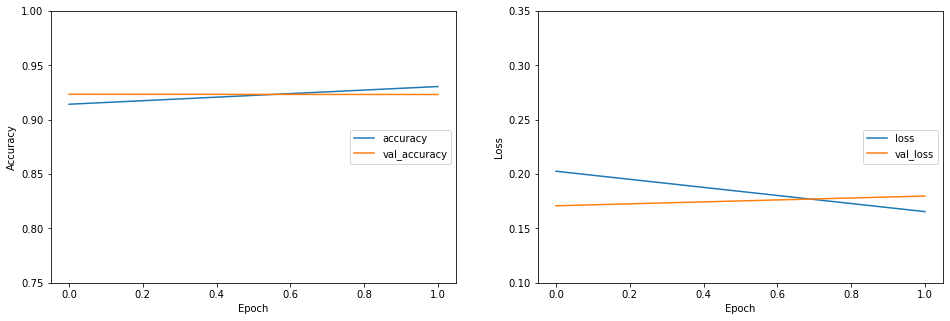

time: 452 ms


In [30]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.plot(epochs_range,train_history.history['accuracy'], label='accuracy')
plt.plot(epochs_range,train_history.history['val_accuracy'], label = 'val_accuracy')
plt.ylim(0.75,1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='center right')

plt.subplot(122)
plt.plot(epochs_range,train_history.history['loss'], label='loss')
plt.plot(epochs_range,train_history.history['val_loss'], label = 'val_loss')
plt.ylim(0.1,0.35)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='center right')

In [31]:
loss,accuracy = model.evaluate(test,verbose=1)
print('Loss = ',loss*100,'%')
print('Accuracy = ',accuracy*100,'%')

85/85 [==============================] - 37s 431ms/step - loss: 0.1713 - accuracy: 0.9268
Loss =  17.12561862433658 %
Accuracy =  92.68495440483093 %
time: 36.9 s


Stage 2

In [32]:
# n_steps = x_valid.shape[0] // BATCH_SIZE
# train_history_2 = model.fit(
#     valid_dataset.repeat(),
#     steps_per_epoch=n_steps,
#     epochs=EPOCHS*2
# )

time: 440 µs


Creating submission file

In [33]:
sub1 = pd.read_csv(data_path + 'sample_submission.csv')
sub1['toxic'] = model.predict(final_test_data, verbose=1)

499/499 [==============================] - 89s 179ms/step
time: 1min 29s


In [34]:
sub1.to_csv('submission.csv', index=False)
sub1.head(15)

,id,toxic
0,0,0.000084
1,1,0.000023
2,2,0.110548
3,3,0.000026
4,4,0.000082
5,5,0.732574
6,6,0.000026
7,7,0.001178
8,8,0.119036
9,9,0.001153


time: 560 ms


# THE END